In [2]:
import ProbabilityFitter as vit
import markovanalyzer as ma
from signalsnap import PlotConfig, SpectrumConfig, SpectrumCalculator
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters
import timeit

Failed to import torch. This is only a problem when you want to use the CUDA backend.
Version 1.0.11


In [1]:
duration = 360
sampling_rate = 2e3

# Switch between systems: "2x2", "3x3"
systemtype = "3x3"

match systemtype:
    case "2x2":
        rates = { "1->2": 400, "2->1": 600 }
        measurement_op = np.array([1, 6])
    case "3x3":     
        rates = {"1->2": 500, "2->1": 200, "2->3": 400, "3->1": 500 }
        measurement_op = np.array([1, 3, 5])
    case "singlePhoton":
        gamma_in = 750
        gamma_out = 250
        gamma_ph = 180
        gamma_det = 1e7
        rates = {"1->3": gamma_out, "3->1": gamma_in, "3->4": gamma_ph, "4->3": gamma_det, "2->4": gamma_out, "4->2": gamma_in, "2->1": gamma_det}
        measurement_op = np.array([1, 2, 5, 6])

system = vit.SimSystem(rates, measurement_op, 0)
print(system.transition_matrix)
states, measurement = system.simulate_discrete_trace(duration, sampling_rate)

datapath = "Enter the data filepath"
np.save(datapath, measurement )
measurement = vit.add_whitenoise(path=datapath, Amplitude=0.5)
np.save(datapath, measurement )

NameError: name 'np' is not defined

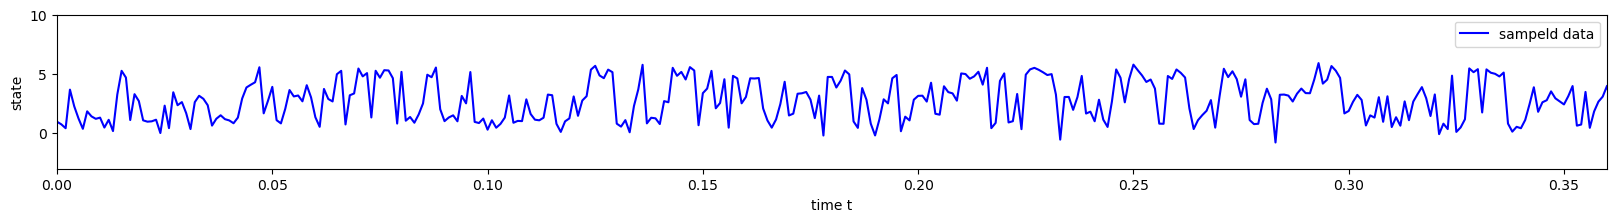

In [11]:
t   = np.linspace(0, duration, len(states))
plt.rcParams['figure.figsize'] = (20, 2)
plt.plot(t, measurement, color='blue', label="sampeld data")
plt.xlim(0, duration*1e-3)
plt.ylim(-3, 10)
plt.xlabel("time t")
plt.ylabel("state")
plt.legend()
plt.show()

In [12]:
match systemtype:
    case "2x2":
        print(systemtype)
        params = Parameters()
        params.add("gamma_12", value=4, min=0, max=1e3)
        params.add("gamma_21", value=3, min=0, max=1e3)
        params.add("n1", value=1, min=0, max=10, vary=False)
        params.add("n2", value=6, min=0, max=10, vary=False)
        params.add("sigma", value=1, min=0.1, max=5, vary=False)

        def set_system(params):
            inital_state = 0
            rates = {   "1->2": params["gamma_12"],
                        "2->1": params["gamma_21"]  }
            
            measurement_op = np.array( [ params["n1"], params["n2"]])
            sigma = np.array( [ params["sigma"], params["sigma"]])

            system = vit.SimSystem(rates, measurement_op, sigma, inital_state)
            return system

    case "3x3":
        print(systemtype)
        params = Parameters()
        params.add("gamma_12", value=3, min=0, max=1e3)
        params.add("gamma_21", value=2, min=0, max=1e3)
        params.add("gamma_23", value=1, min=0, max=1e3)
        params.add("n1", value=1, min=0, max=10, vary=False)
        params.add("n2", value=6, min=0, max=10, vary=False)
        params.add("n3", value=12, min=0, max=10, vary=False)
        params.add("sigma", value=1, min=0, max=1, vary=False)

        def set_system(params):
            inital_state = 0
            rates = {   "1->2": params["gamma_12"],
                        "2->1": params["gamma_21"],  
                        "2->3": params["gamma_23"],
                        "3->1": params["gamma_12"] }
            
            measurement_op = np.array( [ params["n1"], params["n2"], params["n3"] ] )
            sigma = np.array( [ params["sigma"], params["sigma"], params["sigma"] ] )

            system = vit.SimSystem(rates, measurement_op, sigma, inital_state)
            return system
        
    case "singlePhoton":
        print(systemtype)
        params = Parameters()
        params.add("gamma_in", value=3, min=0, max=1e3)
        params.add("gamma_out", value=2, min=0, max=1e3)
        params.add("gamma_det", value=1, min=0, max=1e3)
        params.add("n1", value=1, min=0, max=10, vary=False)
        params.add("n2", value=3, min=0, max=10, vary=False)
        params.add("n3", value=5, min=0, max=10, vary=False)
        params.add("sigma", value=1, min=0, max=1, vary=False)

        def set_system(params):
            inital_state = 0
            rates = {   "1->2": params["gamma_12"],
                        "2->1": params["gamma_21"],
                        "2->3": params["gamma_23"],
                        "3->1": params["gamma_12"] }
            
            measurement_op = np.array( [ params["n1"], params["n2"], params["n3"] ] )
            sigma = np.array( [ params["sigma"], params["sigma"], params["sigma"] ] )

            system = vit.SimSystem(rates, measurement_op, sigma, inital_state)
            return system
        

fitsystem = vit.FitSystem(set_system, datapath, sampling_rate)
result = fitsystem.fit_sampled_noisy_data(params)

result

3x3


### Polyspectra Fit

T_window: 2.980e-01 s
Maximum frequency: 5.000e+02 Hz


  0%|          | 0/120 [00:00<?, ?it/s]

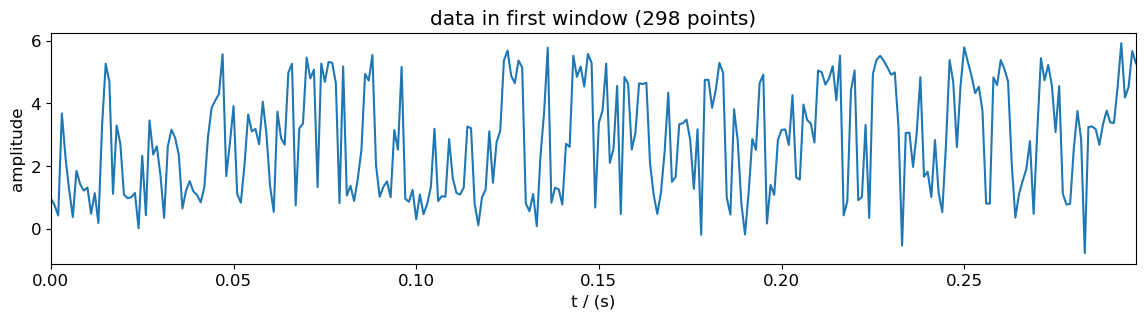

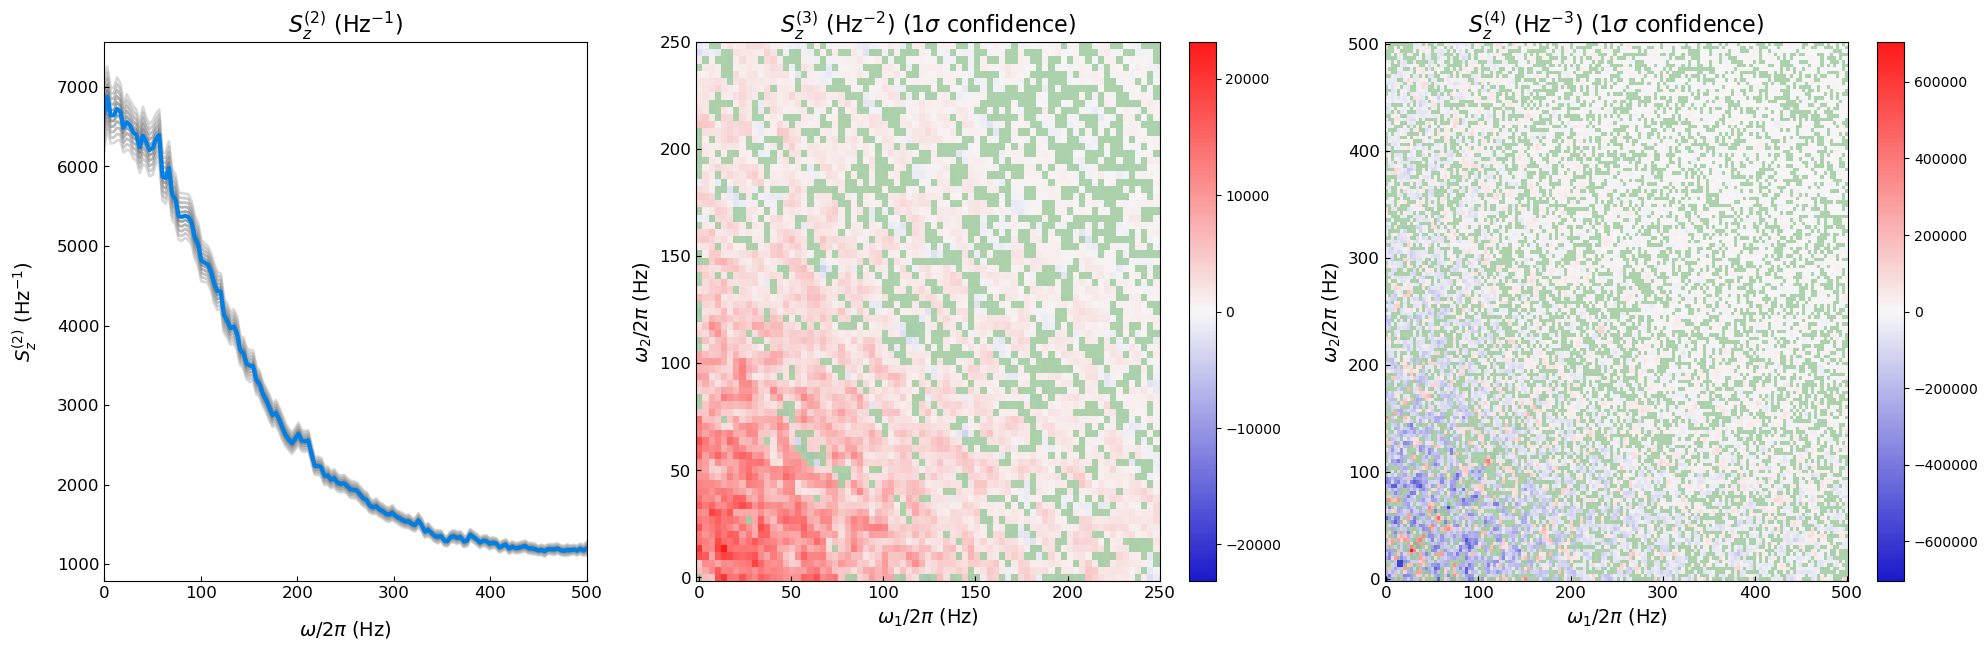

In [13]:
match systemtype:
    case "2x2":
        parameters = {'gamma_12': [4, 0, 1e3, True],
                    'gamma_21': [3, 0, 1e3, True],
                    'n_1': [sampling_rate*1, 0, 1e6, False], # n_1 * samplingrate
                    'n_2': [sampling_rate*6, 0, 1e6, False], 
                    'c': [1000 , -1e6, 1e6, True]}

        def set_system(params):
            rates = {   "1->2": params["gamma_12"],
                        "2->1": params["gamma_21"]  }
            
            measurement_op = np.array( [ params["n_1"], params["n_2"]])

            markov_system = ma.System(rates, measurement_op)
            return markov_system
        
    case "3x3":
        parameters = {'gamma_12': [4, 0, 1e3, True],
                    'gamma_21': [3, 0, 1e3, True],
                    'gamma_23': [5, 0, 1e3, True],
                    'n_1': [sampling_rate*1, 0, 1e6, False], # n_1 * samplingrate
                    'n_2': [sampling_rate*6, 0, 1e6, False], 
                    'n_3': [sampling_rate*12, 0, 1e6, False],
                    'c': [1000 , -1e6, 1e6, True]}

        def set_system(params):
            rates = {   "1->2": params["gamma_12"],
                        "2->1": params["gamma_21"]  }
            
            measurement_op = np.array( [ params["n_1"], params["n_2"]])

            markov_system = ma.System(rates, measurement_op)
            return markov_system
        


starttime = timeit.default_timer()
# ========== Calculating Spectra's =================
dt = 1/sampling_rate
f_max = sampling_rate/2
data = np.load(datapath)
config = SpectrumConfig(delta_t=1/sampling_rate, data=data, f_unit='Hz', 
                        spectrum_size=150, order_in='all', 
                        f_max=f_max, backend='cpu')

spec1 = SpectrumCalculator(config)
f, s, serr = spec1.calc_spec()
spectra_path = "Enter location of the spectra"
spec1.save_spec(spectra_path, remove_S_stationarity=True)

plot_config = PlotConfig(plot_orders=[2,3,4], arcsinh_plot=False, arcsinh_const=0.0002)
fig = spec1.plot(plot_config)

# ========= Fitting the Polyspectra ==============
fitsystem = ma.FitSystem(set_system)
result = fitsystem.complete_fit(spectra_path, parameters, 
                method='least_squares', xtol=1e-8, ftol=1e-8, show_plot=False, fit_modus='resolution_based',
                fit_orders=(1,2,3,4), beta_offset=False) #, realtime_plot=True
runtime = timeit.default_timer() - starttime
fit12 = result.params["gamma_12"].value
fit21 = result.params["gamma_21"].value
print(f"After {runtime:.04f} seconds: \n   gamma_12: {fit12} \n   gamma_21: {fit21} ")

### Code profiling

In [6]:
# Load Scalene
%load_ext scalene

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


In [7]:
# Profile just one line of code
%scrun --profile-all fitsystem.fit_sampled_noisy_data(params)

SCRUN MAGIC
Sigma: 1
In: 2.0000000000000018
Out: 3.0000000000000027
n1: 1
n2: 6
ln(p_trace): -144911.22319638936 

Sigma: 1
In: 2.0000000000000018
Out: 3.0000000000000027
n1: 1
n2: 6
ln(p_trace): -144911.22319638936 

Sigma: 1
In: 2.0000000000000018
Out: 3.0000000000000027
n1: 1
n2: 6
ln(p_trace): -144911.22319638936 

Sigma: 1
In: 2.0006618599666126
Out: 3.0000000000000027
n1: 1
n2: 6
ln(p_trace): -144907.02927583936 

Sigma: 1
In: 2.0000000000000018
Out: 3.00079918220042
n1: 1
n2: 6
ln(p_trace): -144913.59798579465 

Sigma: 1
In: 0.1858262649971354
Out: 185.449675821321
n1: 1
n2: 6
ln(p_trace): -1624887.4759071926 

Sigma: 1
In: 4.238608254641174
Out: 0.37002941419295166
n1: 1
n2: 6
ln(p_trace): -148123.76093425494 

Sigma: 1
In: 2.9745850578706268
Out: 1.418706511642276
n1: 1
n2: 6
ln(p_trace): -139024.50384289215 

Sigma: 1
In: 2.9753811116904894
Out: 1.418706511642276
n1: 1
n2: 6
ln(p_trace): -139021.57516945203 

Sigma: 1
In: 2.9745850578706268
Out: 1.4192694386055416
n1: 1
n2: 6

### Überprüfen, dass Sigma in der Gaussverteilung wirklich 1:1 mit der Noise-Amplitude skaliert: Antwort ja!

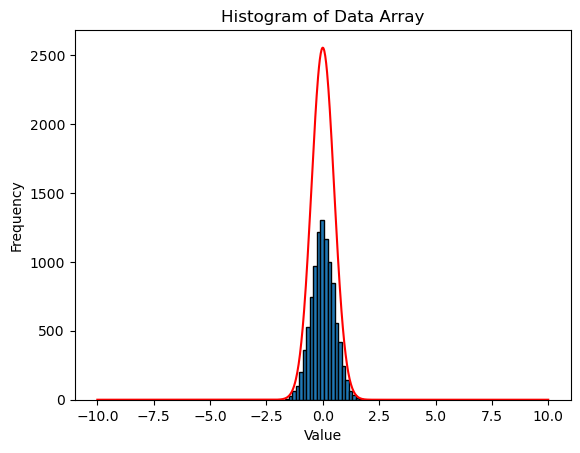

In [18]:
def gauss(x, sigma, mu):
    """
    Gaussian standarddistribution with peak mu and standarddeviation sigma
    """
    result = (1 / (np.sqrt(2*np.pi) * sigma) ) * np.exp( -0.5 * ((mu - x) / (sigma))**2 )
    return result

Amplitude = 0.5
noise = Amplitude * np.random.standard_normal(10000)
x = np.linspace(-10, 10, 1000)

# Plotting the histogram
plt.hist(noise, bins=25, edgecolor='black')
plt.plot(x, 3200*gauss(x, Amplitude, 0), color="red",)
# Adding titles and labels
plt.title('Histogram of Data Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()